In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## Ready the data

In [2]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples=1000

#Create circles
X,y=make_circles(n_samples,noise=0.05,random_state=42)

len(X),len(y)

(1000, 1000)

In [3]:
print("X samples\n",X[:5])
print("y samples\n",y[:5])

X samples
 [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
y samples
 [1 1 1 1 0]


In [4]:
#Make dataframe for circle data
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"Label":y})
circles.head()

,X1,X2,Label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


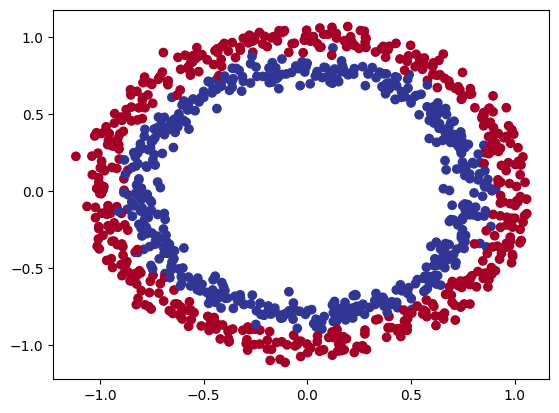

In [5]:
#Visualizing the data
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

### Check for input and output shapes

In [6]:
X.shape,y.shape,X.dtype,y.dtype

((1000, 2), (1000,), dtype('float64'), dtype('int64'))

### Convert Data to Tensors

In [7]:
torch.__version__

'2.4.1+cu121'

In [8]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7422,  0.2467],
         [-0.7340,  0.1687],
         [-0.8299,  0.2220],
         [-0.4291,  0.6722],
         [ 0.4456, -0.8949]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
X.dtype,y.dtype

(torch.float32, torch.float32)

### Split the data in train and test set

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.2,
                                               random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


## Device Agnostic Code

In [11]:
device='cuda' if torch.cuda.is_available() else "cpu"
print(f"Device:{device}")

Device:cuda


## Building the model

In [12]:
from torch import nn

In [13]:
class circleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    #Create 2 nn.Linear layer
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layer_2=nn.Linear(in_features=5,out_features=1)

  #sefDefine the forward method
  def forward(self,x):
    return self.layer_2(self.layer_1(x))

In [14]:
#Intialize the mdoel and send to the device
model0=circleModelv0().to(device)
model0

circleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [16]:
#Replicating the above model using nn.Sequential
model0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6625, -0.0703],
                      [-0.3705, -0.5740],
                      [ 0.1285, -0.2951],
                      [-0.5602, -0.2653],
                      [ 0.2606,  0.0155]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6310, -0.5163, -0.1231,  0.1291,  0.2875], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0188, -0.4267, -0.0999,  0.1238, -0.3669]], device='cuda:0')),
             ('1.bias', tensor([0.3432], device='cuda:0'))])

In [18]:
with torch.inference_mode():
  untrained_preds=model0(X_test.to(device))
print(f'Length of predictions {len(untrained_preds)}, Shape {untrained_preds.shape}')
print(f'Length of predictions {len(X_test)}, Shape {X_test.shape}')
print("First 10 prediction\n",untrained_preds[:10])
print("First 10 labels\n",y_test[:10])

Length of predictions 200, Shape torch.Size([200, 1])
Length of predictions 200, Shape torch.Size([200, 2])
First 10 prediction
 tensor([[0.6696],
        [0.7179],
        [0.4482],
        [0.7392],
        [0.2986],
        [0.3324],
        [0.5977],
        [0.5111],
        [0.4397],
        [0.7238]], device='cuda:0')
First 10 labels
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Loss and optimizer Function

In [19]:
loss_fn=torch.nn.BCEWithLogitsLoss()  #Sigmoid activation fucntion builtin (Sigmoid + BCELoss)
optimizer=torch.optim.SGD(params=model0.parameters(),lr=0.01)

In [20]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6625, -0.0703],
                      [-0.3705, -0.5740],
                      [ 0.1285, -0.2951],
                      [-0.5602, -0.2653],
                      [ 0.2606,  0.0155]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6310, -0.5163, -0.1231,  0.1291,  0.2875], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0188, -0.4267, -0.0999,  0.1238, -0.3669]], device='cuda:0')),
             ('1.bias', tensor([0.3432], device='cuda:0'))])

In [21]:
#Calculate accuarcy

def accuracy_fn(y_true,y_preds):
  correct=torch.eq(y_true,y_preds).sum().item()
  acc=(correct/len(y_preds))*100
  return acc

## Training the model

We can convert the **logits** into **prediction probabilities** by passing them through an activation function (sigmoid for binary classification and softmax for multiclass classification)
Then we convert the model prediction probabilities to **prediction labels** by either rounding them or taking the argmax()

In [22]:
!nvidia-smi

Mon Sep 30 06:59:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              26W /  70W |    151MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
%%time
#Initialize the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of epochs
epochs=1000

#Get teh data to the target device based on agnostic code
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

#Training Loop
for epoch in range(epochs):
  #Training
  model0.train()

  #Forward pass
  y_logits=model0(X_train).squeeze()

  #Convert logits to prediction labels
  y_preds=torch.round(torch.sigmoid(y_logits))

  #Calculate Loss and Accuracy
  loss=loss_fn(y_logits,y_train)  #y_logits as input as we use BCEWithLogitsLoss()
  accuracy=accuracy_fn(y_true=y_train,y_preds=y_preds)

  #Optimizer Zero Grad
  optimizer.zero_grad()

  #Backward Pass (BackPropogation)
  loss.backward()

  #Optimizer Step (gradient descent)
  optimizer.step()

  #Testinf Loop
  model0.eval()
  with torch.inference_mode():
    #Calculate teh logits using model0 on test data
    test_logits=model0(X_test).squeeze()

    #Convert logits to prediction labels
    test_preds=torch.round(torch.sigmoid(test_logits))

    #Calculate loss and Accuracy
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_test,test_preds)

  #Print the results
  if epoch%100==0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}% | Test loss:{test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch:0 | Loss: 0.72491 | Accuracy: 50.00% | Test loss:0.73277 | Test Accuracy: 50.00%
Epoch:10 | Loss: 0.72181 | Accuracy: 50.00% | Test loss:0.72945 | Test Accuracy: 50.00%
Epoch:20 | Loss: 0.71902 | Accuracy: 50.00% | Test loss:0.72645 | Test Accuracy: 50.00%
Epoch:30 | Loss: 0.71649 | Accuracy: 50.00% | Test loss:0.72373 | Test Accuracy: 50.00%
Epoch:40 | Loss: 0.71422 | Accuracy: 50.00% | Test loss:0.72127 | Test Accuracy: 50.00%
Epoch:50 | Loss: 0.71217 | Accuracy: 50.00% | Test loss:0.71905 | Test Accuracy: 50.00%
Epoch:60 | Loss: 0.71032 | Accuracy: 50.00% | Test loss:0.71703 | Test Accuracy: 50.00%
Epoch:70 | Loss: 0.70865 | Accuracy: 50.00% | Test loss:0.71521 | Test Accuracy: 50.00%
Epoch:80 | Loss: 0.70715 | Accuracy: 50.00% | Test loss:0.71356 | Test Accuracy: 50.00%
Epoch:90 | Loss: 0.70579 | Accuracy: 50.00% | Test loss:0.71206 | Test Accuracy: 50.00%
Epoch:100 | Loss: 0.70457 | Accuracy: 50.00% | Test loss:0.71070 | Test Accuracy: 50.00%
Epoch:110 | Loss: 0.70346 | Accu

## Visualize the Predictions

In [24]:
#To visualize we use the fuction `plot_decision_boundary()`
import requests
from pathlib import Path

#Download helper functions from LearnPytorch repo
if Path("helper_function.py").is_file():
  print("Already Exist!")
else:
  print("Downloading...")
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open("helper_function.py","wb") as f:
    f.write(request.content)
from helper_function import plot_decision_boundary,plot_predictions

Downloading...


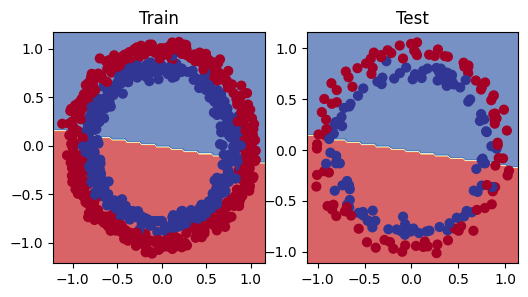

In [25]:
#Plot the decision boundary for the model
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,X_test,y_test)

## Improving the model

* Add more layers: give the model more chances to learn about parameters in the data.
* Add more hidden units
* Fit for longer : increase the number of epochs
* Changing the activation function
* Change the learning rate
* Change the loss function


In [26]:
class circleModelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2,out_features=10)
    self.layer2=nn.Linear(in_features=10,out_features=10)
    self.layer3=nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    z=self.layer1(x)
    z=self.layer2(z)
    z=self.layer3(z)
    return z
    # Or return self.layer3(self.layer2(self.layer1(x)))

model1=circleModelv1().to(device)
model1


circleModelv1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
loss_fn=torch.nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model1.parameters(),lr=0.1)

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model1.train()

  y_logits=model1(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_train,y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model1.eval()
  with torch.inference_mode():
    test_logits=model1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    teat_acc=accuracy_fn(y_test,test_pred)

  if epoch%100==0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss:{test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch:0 | Loss: 0.69393 | Accuracy: 51.00% | Test loss:0.69264 | Test Accuracy: 46.50%
Epoch:100 | Loss: 0.69305 | Accuracy: 50.50% | Test loss:0.69379 | Test Accuracy: 46.50%
Epoch:200 | Loss: 0.69299 | Accuracy: 51.12% | Test loss:0.69436 | Test Accuracy: 46.50%
Epoch:300 | Loss: 0.69298 | Accuracy: 51.00% | Test loss:0.69456 | Test Accuracy: 46.50%
Epoch:400 | Loss: 0.69298 | Accuracy: 51.38% | Test loss:0.69463 | Test Accuracy: 46.50%
Epoch:500 | Loss: 0.69298 | Accuracy: 51.62% | Test loss:0.69465 | Test Accuracy: 46.50%
Epoch:600 | Loss: 0.69298 | Accuracy: 51.62% | Test loss:0.69466 | Test Accuracy: 46.50%
Epoch:700 | Loss: 0.69298 | Accuracy: 51.62% | Test loss:0.69466 | Test Accuracy: 46.50%
Epoch:800 | Loss: 0.69298 | Accuracy: 51.62% | Test loss:0.69466 | Test Accuracy: 46.50%
Epoch:900 | Loss: 0.69298 | Accuracy: 51.62% | Test loss:0.69466 | Test Accuracy: 46.50%


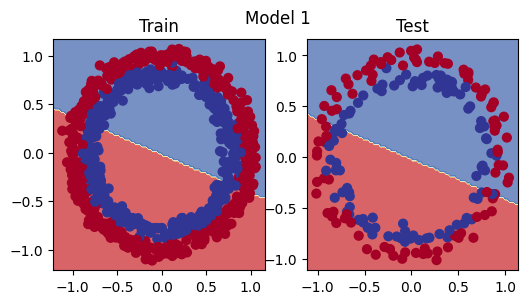

In [29]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.suptitle("Model 1")
plt.title("Train")
plot_decision_boundary(model1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1,X_test,y_test)

## Building Model using Non-linear function

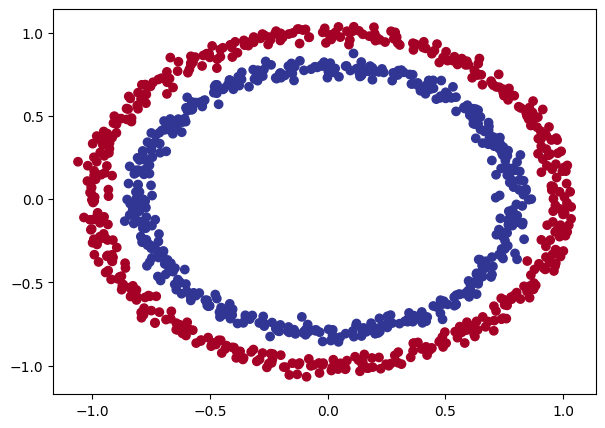

In [69]:
# make and plot data

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)
plt.figure(figsize=(7,5))
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [70]:
import torch
from sklearn.model_selection import train_test_split

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [71]:
from torch import nn

class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2,out_features=10)
    self.layer2=nn.Linear(in_features=10,out_features=10)
    self.layer3=nn.Linear(in_features=10,out_features=1)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model3=CircleModelv2().to(device)
model3

CircleModelv2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [72]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model3.parameters(),lr=0.1)

In [73]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1500

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model3.train()
  y_logits=model3.forward(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model3.eval()
  with torch.inference_mode():
    test_logits=model3(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_test,test_pred)

  if epoch%100==0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss:{test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch:0 | Loss: 0.69295 | Accuracy: 50.00% | Test loss:0.69319 | Test Accuracy: 50.00%
Epoch:100 | Loss: 0.69115 | Accuracy: 52.88% | Test loss:0.69102 | Test Accuracy: 52.50%
Epoch:200 | Loss: 0.68977 | Accuracy: 53.37% | Test loss:0.68940 | Test Accuracy: 55.00%
Epoch:300 | Loss: 0.68795 | Accuracy: 53.00% | Test loss:0.68723 | Test Accuracy: 56.00%
Epoch:400 | Loss: 0.68517 | Accuracy: 52.75% | Test loss:0.68411 | Test Accuracy: 56.50%
Epoch:500 | Loss: 0.68102 | Accuracy: 52.75% | Test loss:0.67941 | Test Accuracy: 56.50%
Epoch:600 | Loss: 0.67515 | Accuracy: 54.50% | Test loss:0.67285 | Test Accuracy: 56.00%
Epoch:700 | Loss: 0.66659 | Accuracy: 58.38% | Test loss:0.66322 | Test Accuracy: 59.00%
Epoch:800 | Loss: 0.65160 | Accuracy: 64.00% | Test loss:0.64757 | Test Accuracy: 67.50%
Epoch:900 | Loss: 0.62362 | Accuracy: 74.00% | Test loss:0.62145 | Test Accuracy: 79.00%
Epoch:1000 | Loss: 0.56818 | Accuracy: 87.75% | Test loss:0.57378 | Test Accuracy: 86.50%
Epoch:1100 | Loss: 0.4

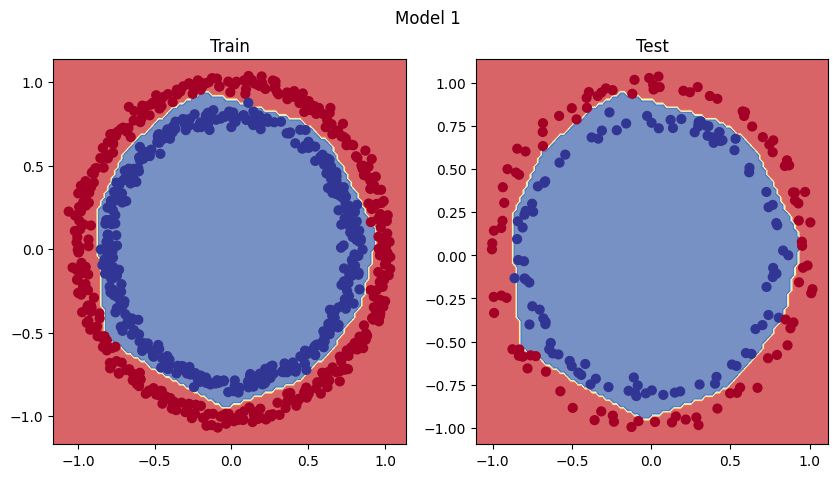

In [74]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.suptitle("Model 1")
plt.title("Train")
plot_decision_boundary(model3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model3,X_test,y_test)